In [42]:
import krakenex
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from requests.exceptions import HTTPError

In [301]:
kraken = krakenex.API()

In [302]:
def get_order_book(pair, count):
    """Queries the kraken order book.

    Parameters
    ----------
    pair : str 
        Asset pair to get market depth for.
    count : int 
        Maximum number of asks/bids

    Returns
    -------
    dataframe
        Order book as dataframe with columns price, volume, timestamp, type, cumvolume, relprice.
    """
    
    try:
        response = kraken.query_public('Depth', {'pair': pair, 'count': count})
    except HTTPError as e:
        print("ERROR: Failed getting order book data for pair={}".format(pair))
    
    obook = response.get('result', {}).get(pair)
    if not obook:
        print("WARNING: Empty response.")
    else:
        # add cumvolume
        asks = [limorder + ['ask'] for limorder in obook['asks']]
        bids = [limorder + ['bid'] for limorder in obook['bids']]
        tabular = asks + bids
        obook = pd.DataFrame(tabular, columns=['price', 'volume', 'timestamp', 'type'])            
        obook = obook.apply(pd.to_numeric, errors='ignore')
        obook['cumvolume'] = obook[['type', 'volume']].groupby('type').cumsum()  # assumes rows are sorted
        
        # add relprice
        minask = obook.loc[obook['type'] == 'ask', 'price'].min()
        maxbid = obook.loc[obook['type'] == 'bid', 'price'].max()
        spread = minask - maxbid
        midprice = (minask + maxbid) / 2
        obook['relprice'] = 100 * (obook['price'] - midprice) / midprice
        
    return obook


def plot_order_book(ob):
    """Plots the cumulative volume and order distribution of the order book.
    
    Paramaters
    ----------
    ob : dataframe
        Order book data frame with columns type, price, volume, cumvolume, relprice.
    """
    
    # extract data series from df
    ask_prices = ob.loc[ob['type'] == 'ask', 'price']
    ask_relprices = ob.loc[ob['type'] == 'ask', 'relprice']
    ask_volumes = ob.loc[ob['type'] == 'ask', 'volume']
    ask_cumvolumes = ob.loc[ob['type'] == 'ask', 'cumvolume']
    bid_prices = ob.loc[ob['type'] == 'bid', 'price']
    bid_relprices = ob.loc[ob['type'] == 'bid', 'relprice']
    bid_volumes = ob.loc[ob['type'] == 'bid', 'volume']
    bid_cumvolumes = ob.loc[ob['type'] == 'bid', 'cumvolume']
    
    # plot cum vol plot
    fig, ax = plt.subplots(2, 1, figsize=(16, 10))  # sharex='col'
    ax[0].fill_between(bid_relprices, bid_cumvolumes, facecolor='maroon', edgecolor='k', alpha=0.7, zorder=10, label='bids')
    ax[0].fill_between(ask_relprices, ask_cumvolumes, facecolor='dimgrey', edgecolor='k', alpha=0.7, zorder=10, label='asks')
    ax[0].set_xlim([min(bid_relprices.min(), ask_relprices.min()), max(bid_relprices.max(), ask_relprices.max())])
    ax[0].set_ylim([0, 1.05* max(bid_cumvolumes.max(), ask_cumvolumes.max())])
    ax[0].set_xlabel('Distance to midprice (%)')
    ax[0].set_ylabel('Cumulative Volume')
    ax[0].legend(loc='upper center', facecolor='white', framealpha=1, frameon=False)
    
    # plot order distribution
    ax[1].stem(bid_prices, bid_volumes, 'maroon', markerfmt=' ', label='bids')
    ax[1].stem(ask_prices, ask_volumes, 'k', markerfmt=' ', label='asks')
    ax[1].set_ylim([0, 1.05* max(bid_volumes.max(), ask_volumes.max())])
    ax[1].set_xlabel('Price')
    ax[1].set_ylabel('Volume')
    
    plt.show()

In [311]:
N = 100
ob = get_order_book('XXRPZEUR', N)
ob.head()

,price,volume,timestamp,type,cumvolume,relprice
0,0.27588,4506.940,1552517314,ask,4506.940,0.074363
1,0.27590,2847.705,1552517306,ask,7354.645,0.081618
2,0.27591,28346.880,1552517311,ask,35701.525,0.085245
3,0.27605,33.260,1552517232,ask,35734.785,0.136030
4,0.27610,707.840,1552517195,ask,36442.625,0.154167


In [387]:
# How much information can we take out while still maintaining the shape of the order book?
threshold = ob.volume.nlargest(int(0.6 * N)).min()
ob_sub = ob.groupby('type').apply(lambda x: x[x['volume'] > threshold])

In [388]:
ob_sub.shape

(59, 6)

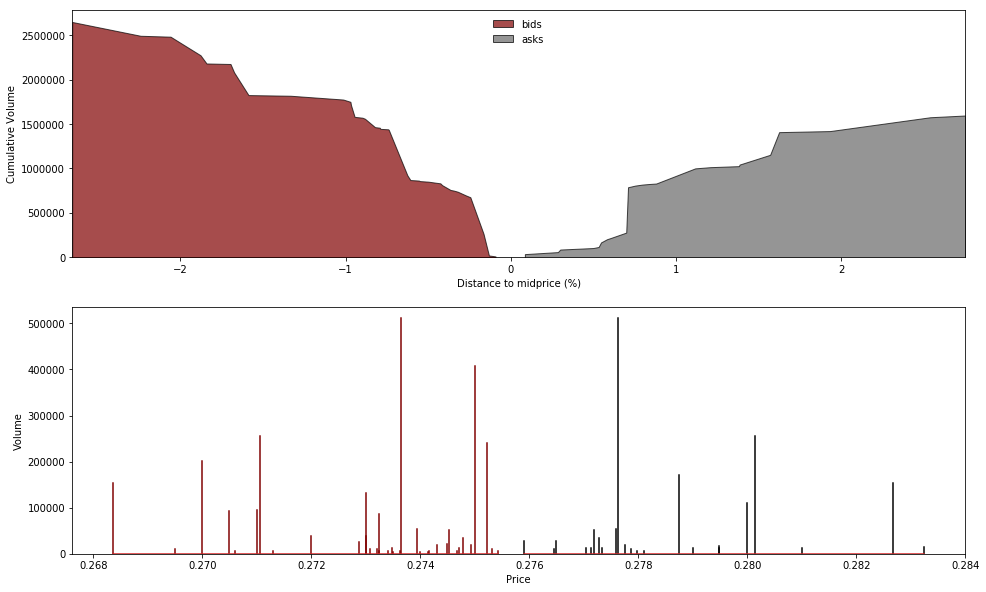

In [389]:
plot_order_book(ob_sub)

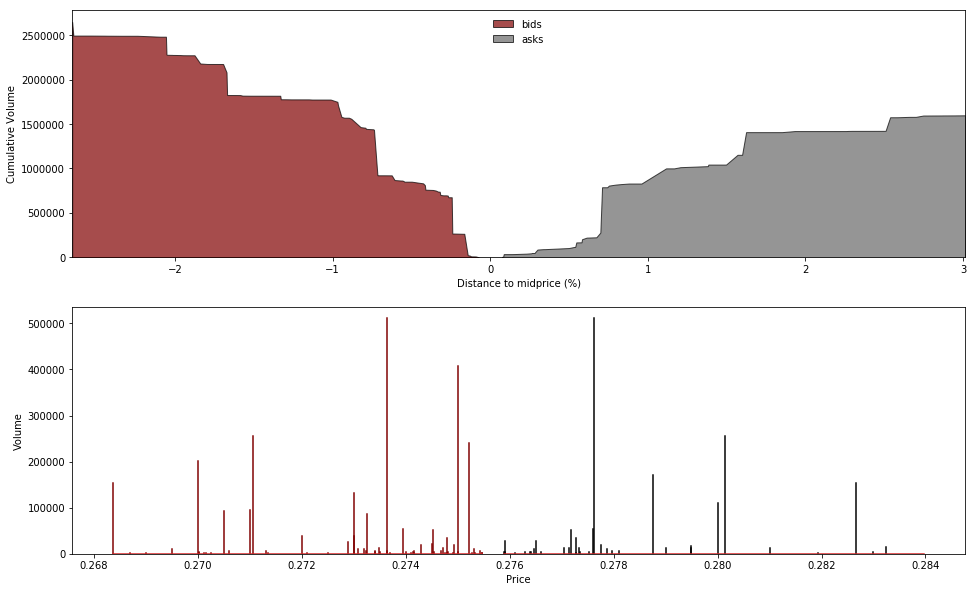

In [390]:
plot_order_book(ob)

In [385]:
def cash_in_orderbook(midpoint, diff, ob):
    """A measure of the relative money needed to move the price from the midprice given the current orders. 
    
    Note that this is normalized by the area of +/- diff about the midprice.

    midprice: float 
        The midpoint of the spread.
    diff : float
        The relative amount in percentage terms you want the price to move from the midpoint.
    ob : dataframe
        The orderbook dataframe or ask / bid dataframe.
    """
    
    oneside = ob[np.less_equal(np.absolute(ob['relprice']), abs(diff)) & (np.sign(ob['relprice']) == np.sign(diff))]
    bothsides = ob[np.less_equal(np.absolute(ob['relprice']), abs(diff))]
    onesidemoney = np.sum(oneside['price'] * oneside['volume'])
    totalmoney = np.sum(bothsides['price'] * bothsides['volume'])
    
    return onesidemoney / totalmoney


def ask_to_total_fraction(ob, ub, n=100):
    """Metric to calculate a series of relative strength of ask vs bid side.
    
    Basically the price weighted order volume on the ask side over the total price weighted order 
    volume within x% of midprice. Returns a series of these at different x%s.
    
    Definition
    ----------
        A / (A + B), where
        A = sum(volume_i * price_i) for the ith order in the ask side between the midprice and the upper bound,
        B = similar metric just for bids.
    
    Parameters
    ----------
    ob : dataframe
        The orderbook with buy and ask orders.
    ub : float
        The relative price upper bound in percent difference from the midpoint.
        
    Returns
    -------
    prices : array
        A linear space of prices.
    metric : array
        The metric calculated at each price point.
    """
    
    asks = ob[ob['type'] == 'ask']
    bids = ob[ob['type'] == 'bid']
    minask = asks.price.min()
    maxbid = bids.price.max()
    
    spread = minask - maxbid
    midprice = (minask + maxbid) / 2
    lb = max(asks.relprice.min(), abs(bids.relprice.max()))  # lower bound
    prices = np.linspace(lb, ub, n)
    metrics = [cash_in_orderbook(midprice, p, ob) for p in prices]
    
    return prices, metrics


def summarize_order_book(ob):
    
    asks = ob[ob['type'] == 'ask']
    bids = ob[ob['type'] == 'bid']
    minask = asks.price.min()
    maxbid = bids.price.max()
    
    spread = minask - maxbid
    midprice = (minask + maxbid) / 2
    spreadperc = 100 * spread / midprice
    
    # first cliff detection
    # define fc as largest vol order within delta% of midpoint
    fc_bounds = 2.0  # percent
    fc_ask = asks.loc[asks.loc[asks['relprice'] > fc_bounds, 'volume'].idxmax()]
    fc_bid = bids.loc[bids.loc[bids['relprice'] > -fc_bounds, 'volume'].idxmax()]
    
    # size of first cliff
    # define sfc as sum of volumes of orders within epsilon% of cliff
    sfc_bounds = 0.1  # percent
    sfc_ask = asks.loc[np.absolute(asks['relprice'] - fc_ask['relprice']) < sfc_bounds, 'volume'].sum()
    sfc_bid = bids.loc[np.absolute(bids['relprice'] - fc_bid['relprice']) < sfc_bounds, 'volume'].sum()
    
    # TODO:
#     Money / volume needed to move price to first cliff edge
#     Money / volume needed to move price to nth interval of first cliff edge
#     USD?
#     divide ask by bids or vice versa to see who has the relative upper hand against percent move from midprice
    
    return midprice, spread, spreadperc

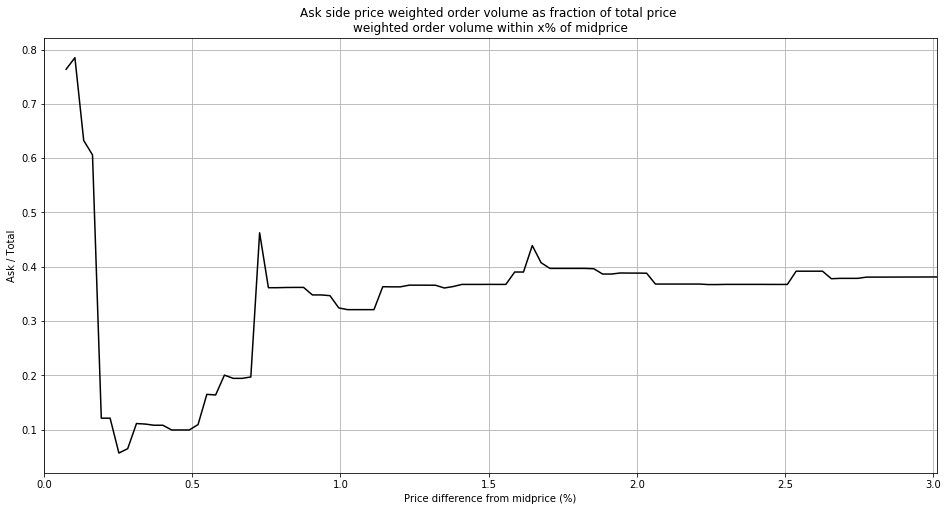

In [384]:
prices, ask = ask_to_total_fraction(ob, np.absolute(ob['relprice']).max())
fig, ax = plt.subplots(figsize=(16, 8))  # sharex='col'
ax.plot(prices, y, 'k')
ax.set_xlim([0, max(x)])
ax.set_title('Ask side price weighted order volume as fraction of total price \nweighted order volume within x% of midprice')
ax.set_xlabel('Price difference from midprice (%)')
ax.set_ylabel('Ask / Total')
ax.grid()

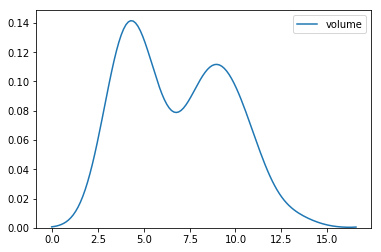

In [121]:
sns.kdeplot(np.log(ob.volume));

In [60]:
np.exp(6.5)

665.1416330443618

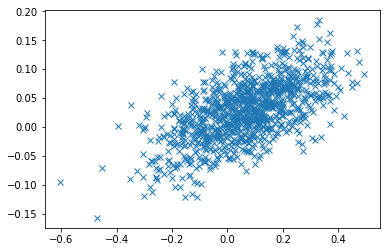

In [394]:
x = [0.2281, 0.196221, 0.0655203, 0.196455, -0.295374, 0.134866, -0.0330969, 0.145831, -0.0699392, -0.0342012, -0.116194, 0.0881727, -0.245102, 0.0354379, -0.0360998, 0.140077, 0.0929664, 0.321416, -0.0907487, -0.0529226, -0.0509926, 0.157312, 0.150122, 0.0715925, 0.147368, -0.0475028, 0.167529, 0.0703422, 0.133563, 0.376231, 0.187976, 0.077268, 0.158239, 0.157816, 0.178254, 0.0360194, 0.0037323, 0.190415, 0.319806, 0.448994, 0.0859069, 0.07128, -0.0859618, 0.0962732, 0.284935, 0.0367351, -0.00383293, 0.0835971, 0.191155, 0.262583, 0.0436768, -0.104151, -0.0474521, -0.0141938, 0.0717128, 0.124311, 0.0597411, -0.187672, 0.288211, 0.156972, 0.158029, 0.231569, -0.0328752, -0.170212, -0.0777519, 0.278413, 0.225939, 0.0819889, -0.130697, -0.0278277, 0.0985403, 0.254274, 0.287683, -0.0101797, 0.0241261, 0.316218, 0.0248033, 0.194587, -0.139372, 0.023479, 0.151466, 0.0207949, 0.301361, 0.107011, 0.330253, 0.238826, 0.121075, -0.0915654, 0.34355, 0.141516, 0.100051, -0.00513526, 0.309805, 0.258605, 0.231283, -0.074013, 0.0233864, 0.181869, -0.0616261, 0.138137, 0.218561, 0.291301, -0.00939151, -0.164761, 0.253185, 0.151546, -0.212172, 0.0429254, 0.0916573, 0.143231, 0.0444317, 0.161306, -0.00639325, 0.0739149, 0.0167924, 0.151518, 0.183504, 0.123493, -0.0901897, -0.00325386, -0.254064, -0.108305, 0.00720326, 0.248484, 0.00620947, 0.249983, 0.135773, 0.148717, -0.012673, -0.0822667, 0.163381, 0.0106938, 0.331754, 0.222408, 0.0643789, 0.281822, 0.180891, -0.246533, 0.0659673, 0.0564771, -0.212862, -0.257885, -0.02652, 0.310288, -0.130041, -0.0959995, 0.117568, -0.091658, 0.0232355, -0.00372526, -0.0446606, -0.240495, 0.0714002, 0.370647, 0.0943641, -0.183405, -0.113354, 0.0360742, 0.366726, 0.0202492, 0.0582172, 0.203245, 0.0199506, -0.0827304, 0.226395, 0.0154401, 0.302264, 0.336386, 0.0312881, 0.127847, 0.129123, 0.066449, 0.467029, 0.0443837, -0.0869173, 0.0899944, 0.191053, -0.0438289, 0.203431, 0.120698, 0.0811022, -0.198738, 0.225248, -0.104987, -0.00420556, -0.304058, 0.11803, 0.384883, 0.0213272, 0.230611, -0.00341626, 0.0660613, 0.0755255, -0.193067, 0.0443496, 0.0562956, 0.000113023, 0.122748, 0.211504, 0.0621566, 0.0463959, 0.0878404, -0.132818, 0.0744519, 0.011723, 0.257162, 0.146941, -0.0298579, 0.141842, -0.0721508, 0.086126, -0.124488, 0.146355, 0.194975, 0.0930049, 0.289829, 0.287345, 0.0553626, -0.130682, 0.197858, -0.163592, 0.0917292, 0.136117, -0.0478305, -0.0670323, 0.136026, 0.157871, -0.0263265, -0.256379, 0.0946384, -0.156069, 0.0745463, 0.21847, 0.203512, -0.0433886, 0.0696336, -0.0330592, -0.0467751, 0.0407172, -0.0391358, 0.174637, -0.0764849, 0.0968701, 0.000575369, 0.333698, 0.0366542, -0.114118, 0.0846309, 0.299526, -0.0486832, -0.165287, 0.193924, 0.308476, 0.0250319, 0.151787, -0.156421, 0.125204, 0.123508, 0.361642, -0.0832623, 0.340341, 0.128277, -0.00632438, 0.222557, 0.267942, 0.108473, 0.0830681, 0.219282, 0.342106, -0.0216257, -0.124303, 0.127812, 0.0653399, -0.156084, 0.190963, 0.134092, 0.224342, -0.0569226, -0.0667479, -0.157682, 0.00571542, -0.0569559, 0.34057, 0.23372, 0.348068, 0.109004, 0.253774, 0.134865, -0.0833889, 0.125021, -0.241118, 0.494689, -0.0569899, 0.155695, 0.357826, -0.0218299, 0.0381878, -0.120156, 0.0386506, -0.0325307, 0.144466, 0.150074, -0.0897034, 0.180203, 0.0365734, 0.125311, -0.118506, -0.216373, -0.119077, -0.194742, 0.190213, 0.150987, 0.162156, -0.104103, 0.0191777, 0.136086, 0.0887024, 0.0843581, 0.0698066, -0.109931, 0.0193652, -0.181514, -0.0624638, 0.143281, 0.0402446, 0.280289, 0.172722, 0.119847, 0.466559, 0.200221, 0.0520312, -0.028994, -0.00567725, -0.0367943, 0.196112, 0.305452, 0.0580999, 0.0926204, -0.0729035, -0.173893, 0.115875, -0.100483, 0.0234346, -0.175001, 0.00982856, 0.166036, -0.318523, 0.278914, 0.0387836, 0.21984, 0.0575398, 0.27162, 0.169557, 0.136571, 0.00604796, -0.146166, -0.15755, 0.383058, 0.0741478, 0.0675388, -0.136269, -0.191748, -0.00498569, 0.137844, 0.26186, 0.167559, 0.185535, -0.105681, -0.125538, 0.0589368, 0.0108786, -0.283407, 0.0659886, 0.47489, 0.0219659, -0.16239, 0.267593, -0.0676925, 0.187456, 0.0628091, 0.0571059, -0.0310922, 0.0781034, -0.146154, 0.0304378, 0.117029, -0.147854, 0.0047308, 0.228236, 0.231514, 0.245398, -0.298458, 0.215724, -0.288983, 0.239574, -0.100648, 0.224351, 0.184918, 0.341222, 0.06489, 0.0763721, 0.0126567, -0.05694, -0.172661, 0.0173479, -0.160033, 0.0335789, -0.135656, 0.0262755, 0.157106, -0.229548, 0.239661, -0.0839085, 0.23302, -0.162769, 0.22975, -0.0318522, -0.0826573, -0.0950587, 0.0318855, 0.278945, -0.0969315, 0.319333, 0.185583, -0.137171, 0.185694, 0.0834916, 0.0484689, 0.0472877, 0.072092, 0.0972223, 0.150665, 0.132048, -0.0876784, 0.0930058, 0.072779, -0.00105734, 0.021817, 0.0626402, -0.0879064, -0.0345394, 0.274181, -0.190959, 0.0967387, 0.102006, 0.369313, 0.251905, 0.253115, 0.219846, 0.119637, 8.18035e-05, 0.0857247, -0.25128, 0.071782, -0.181375, 0.371186, 0.157956, 0.135999, 0.186004, 0.112692, 0.113294, -0.161009, 0.130695, 0.177741, 0.010099, -0.12152, 0.0781452, -0.00852438, 0.310406, -0.155571, -0.0791341, 0.170174, 0.202225, 0.017069, -0.0382914, 0.0369035, 0.0831631, 0.20905, 0.079088, 0.272991, -0.0158206, 0.105272, 0.0769545, -0.233837, -0.0847648, 0.359344, 0.06774, 0.000915221, 0.22273, -0.089636, 0.18042, 0.239871, 0.266028, -0.0333053, 0.0748535, 0.0596047, 0.125572, 0.194275, 0.119545, -0.0864795, -0.251804, 0.237017, -0.217863, 0.232468, 0.126801, 0.179628, 0.24892, 0.062964, 0.164282, 0.134252, 0.348569, 0.0962467, 0.210919, -0.0135801, 0.0704931, 0.0687546, 0.34355, 0.0336473, -0.0400694, 0.0315964, -0.0348082, -0.012462, 0.141515, -0.0141005, 0.128924, 0.372529, 0.136958, 0.361209, 0.0406492, 0.270456, 0.120825, 0.368647, 0.190882, -0.278751, 0.352082, -0.154301, 0.210718, 0.253244, 0.269425, 0.204783, 0.0227638, 0.0172156, 0.199853, 0.158071, 0.344294, -0.157146, 0.176755, -0.0148312, 0.0557268, 0.0157976, 0.156892, 0.296707, 0.169355, 0.0573893, 0.249131, 0.124415, -0.05297, 0.12476, 0.0435622, 0.286694, 0.196474, -0.472302, 0.135129, 0.0960853, 0.10281, -0.111745, 0.0727067, -0.134391, 0.171848, 0.274181, 0.270863, 0.100702, -0.184536, 0.1187, 0.411939, 0.319309, -0.166151, 0.0924813, 0.156754, 0.0145077, 0.191925, -0.196528, -0.1554, -0.270918, -0.0312548, 0.139887, 0.250482, -0.194177, -0.201708, 0.0608026, 0.363773, 0.0926883, 0.0952779, 0.0216447, 0.0249895, -0.302854, 0.136929, -0.0105147, -0.169692, 0.0770298, 0.22506, 0.137891, -0.0897334, -0.0557204, -0.0527702, 0.112551, 0.034299, 0.0985352, 0.0478091, -0.304097, -0.0836394, -0.151497, -0.0247341, -0.0401389, 0.0273942, 0.393886, -0.103476, 0.0581845, -0.12699, 0.0463639, 0.108907, 0.199587, 0.141196, 0.0952442, -0.0287068, -0.0466678, -0.0316249, 0.112535, -0.0372283, -0.0318622, -0.136281, -0.049086, 0.0731698, -0.126804, 0.271387, -0.326991, -0.100375, 0.171528, 0.0589752, -0.0346213, 0.0957687, -0.0452601, 0.241567, 0.0228533, 0.282614, -0.153964, 0.132226, -0.39648, 0.273363, 0.0589297, 0.0100889, 0.0393262, -0.0389566, 0.344533, 0.0791584, 0.157435, -0.17584, 0.406989, -0.60468, -0.111297, -0.0576883, 0.17321, 0.250038, -0.10416, -0.112997, 0.0387074, 0.0950869, 0.212677, 0.323181, -0.0645935, -0.0127389, 0.236195, 0.0948978, 0.11347, 0.103572, 0.298024, 0.178631, -0.0107688, -0.050544, 0.164103, 0.199179, -0.206628, 0.0892794, -0.0751764, -0.0897392, 0.322035, -0.0318628, 0.0378879, 0.245144, -0.0804368, -0.216518, -0.0529249, -0.230139, 0.0148735, 0.11104, 0.199731, -0.0277681, -0.300171, 0.134723, -0.0109273, 0.241405, -0.0612713, 0.104971, 0.0348592, 0.0340895, -0.216456, 0.0322811, 0.18822, -0.0596446, -0.116635, -0.110746, 0.174823, 0.116056, 0.162101, 0.257795, -0.228415, -0.133204, -0.0721186, 0.0380141, 0.0782283, 0.287936, -0.0538752, 0.318381, -0.454281, 0.101932, 0.0154267, -0.351116, 0.196159, 0.0920561, 0.152394, 0.198279, 0.303902, 0.0987943, -0.281162, -0.0224678, 0.326673, -0.00266471, -0.172462, 0.0649038, -0.0395004, -0.0412026, 0.261944, -0.193068, 0.0636138, 0.187209, 0.0181543, 0.255599, -0.037127, 0.104428, 0.0364262, 0.194033, -0.0778689, 0.0909447, 0.20844, 0.315426, -0.163328, -0.0818708, -0.00391347, -0.126587, -0.187947, -0.0108718, -0.085376, 0.355299, 0.131117, -0.151591, 0.0949082, 0.0365354, 0.178404, 0.239375, 0.347612, 0.0582112, 0.0437812, -0.107547, 0.0362666, 0.0490279, 0.0416473, 0.133671, -0.104851, 0.144859, 0.00841077, -0.0674884, 0.155418, 0.135326, -0.194734, -0.138682, 0.125392, 0.0543539, 0.186687, -0.0727465, 0.249984, -0.207064, -0.0684887, 0.192708, 0.175442, 0.223111, 0.0837751, 0.0363598, -0.260542, 0.184767, 0.0126936, -0.0756041, -0.256452, 0.274824, 0.199575, -0.102465, -0.254729, 0.370454, -0.080175, 0.287002, 0.171618, 0.0551734, -0.0361045, 0.0162729, 0.055787, 0.290193, 0.0786729, -0.0893932, -0.00693472, 0.116142, 0.0707775, 0.129386, 0.214413, 0.0765453, 0.0232882, -0.194279, 0.105032, 0.181411, 0.0142594, 0.118851, -0.192744, -0.00662315, 0.0804771, -0.081645, -0.0130204, 0.0226234, 0.0988804, -0.000940814, -0.273764, 0.431139, -0.027688, -0.126746, 0.281669, -0.0192865, 0.0966743, 0.0326297, -0.0672338, -0.0698091, -0.349271, 0.148579, 0.0348119, -0.14523, 0.252716, -0.0421123, 0.204245, -0.172567, 0.11564, -0.0246281, 0.108781, -0.143386, 0.139774, -0.0501291, 0.112136, 0.0537842, 0.0201156, 0.0616139, 0.0552707, 0.41935, 0.0678464, 0.0845514, -0.129747, -0.24481, 0.272493, 0.208441, -0.04339, 0.220954, -0.0286079, 0.258626, 0.192682, 0.271692, 0.161709, -0.0874863, -0.100682, 0.202435, 0.255317, 0.1133, 0.0817846, -0.0712866, 0.174689, 0.171906, 0.246764, 0.398247, 0.0640795, 0.127846, 0.0945789, 0.226498, 0.010591, -0.126358, 0.15698, 0.0729304, 0.0939137, 0.327586, 0.261175, 0.0613146, -0.0429158, -0.0610919, 0.220347, -0.0924014, 0.0548725, 0.210496, 0.026487, 0.0920915, 0.0760287, -0.154115, 0.0927289, -0.133415, 0.110384, -0.160063, 0.00326531, 0.0141387, 0.314863, 0.217628, 0.11876, 0.0930957, -0.114176, 0.0122106, -0.216231, -0.0724327, -0.0757392, -0.00846899, 0.181018, 0.366884, 0.079012, 0.0939285, 0.251035, 0.448486, -0.0647334, -0.276299, 0.19056, 0.219467, 0.0643286, -0.112905, 0.433775, 0.191734, 0.330677, -0.0184983, -0.0913651, -0.0819513, -0.151296, -0.0985957, 0.15531, 0.209943, 0.0771081, -0.115081, -0.0559977, 0.00241328, 0.0479451, 0.139603, 0.169179, 0.164367, 0.132251, -0.12225, -0.0186972, 0.132802, 0.0730372, 0.227949, 0.0552687, -0.209149, 0.0512767, 0.0491032, 0.350629, 0.374073, 0.0821089, 0.385942, 0.0767551, 0.196592, 0.100121, -0.0896244, 0.100146, 0.373368, 0.026854, 0.165113, 0.296839, 0.270114, 0.12763, 0.0434516, 0.251293, -0.128366, 0.0852325, 0.156648, 0.0653703, 0.0442266, 0.0384544, 0.101873, -0.192776, 0.225979, 0.0427861, -0.306172, 0.167318, -0.0446971, 0.123158]
y = [0.0881608, 0.0311361, -0.0244603, 0.0213935, 0.01668, 0.0775284, -0.0123062, 0.0403474, -0.0221785, 0.0716506, 0.0401898, 0.0723154, -0.0526468, -0.0518724, 0.0433016, 0.0127501, 0.0498916, 0.0583847, 0.0994815, 0.0242436, 0.0524278, 0.0644209, 0.0650534, 0.0281589, 0.0419559, 0.0284973, 0.0405403, 0.0237399, 0.0646463, 0.131727, 0.0251406, 0.0558736, 0.0737505, 0.0442102, 0.0626441, 0.0180985, -0.000439082, 0.0644915, 0.0798655, 0.0690577, -0.010813, 0.0109584, -0.0230126, 0.0811974, 0.0793343, 0.104778, -0.0176321, 0.0443337, 0.0768829, 0.00807957, 0.0224978, -0.00943156, -0.0283106, -0.0347214, 0.0141343, 0.0607682, 0.0916998, -0.0713892, 0.0924151, 0.0762995, 0.0134829, 0.0729056, -0.00567156, 0.0200065, -0.0400476, 0.0162589, 0.0721824, -0.016429, 0.0596436, -0.000745583, 0.017916, 0.0954205, 0.0861556, -0.0105655, 0.0451447, 0.0448723, 0.0165151, 0.129006, -0.0641335, -0.00886876, 0.013328, 0.103614, 0.0544071, 0.0275111, 0.184456, 0.0553468, 0.063838, 0.00704846, 0.105932, 0.0341166, 0.0195812, 0.00884867, 0.0255511, -0.00973562, 0.0475287, 0.0270071, 0.0777115, 0.0585632, -0.0680391, 0.0389272, 0.0831034, 0.0384645, 0.0715598, -0.088098, 0.0536598, 0.0639698, -0.0260227, 0.0534833, 0.0706863, 0.04087, 0.0231316, 0.0335424, 0.0344754, 0.0124582, 0.0288499, -0.0391648, 0.0382346, 0.073253, 0.0323093, 0.0266472, -0.0513609, 0.0246435, 0.0454358, 0.0155223, -0.0545691, 0.0978749, 0.033173, -0.0268488, 0.0187608, -0.0518776, 0.0778943, 0.0153305, 0.152535, 0.101235, 0.108439, 0.0966178, 0.0985878, -0.0181918, 0.0143163, 0.0277025, -0.0564116, -0.0703548, -0.0493483, 0.0905675, -0.012619, -0.00842616, 0.0477118, 0.029452, -0.000444326, -0.0470154, 0.0430943, -0.000161596, 0.0445198, 0.124215, 0.0149503, -0.0299687, -0.00968241, 0.0142253, 0.0976975, 0.00901473, 0.0588054, 0.107058, 0.00250633, 0.0782914, 0.0818767, 0.0829578, 0.0286126, -0.0169618, 0.0107068, 0.0252769, -0.00848201, 0.0318254, 0.131215, 0.0706931, -0.00304496, 0.114305, 0.0420551, 0.0165721, -0.00227259, -0.00323709, 0.066069, -0.0884471, 0.0261199, -0.025848, -0.0179151, -0.0871854, 0.00465088, 0.0910313, 0.108306, 0.0635467, 0.0365516, -0.076778, 0.0318855, 0.0247269, 0.0542277, 0.0449299, 0.00497944, 0.0553374, 0.0635242, 0.0731304, -0.00711352, 0.130318, -0.0259984, 0.0484729, -0.00935246, 0.115255, 0.0350793, 0.0609547, 0.0112835, 0.029157, 0.0564219, -0.0193935, 0.0526649, 0.00525034, 0.0508365, 0.116903, 0.00292081, 0.0550949, 0.0380035, 0.110294, -0.0173281, 0.0255413, 0.0333754, 0.0196316, -0.0241273, 0.0718671, 0.0592774, 0.010921, -0.0887353, 0.0508869, 0.0190994, 0.00393145, 0.0804421, 0.123882, -0.0673105, 0.0807258, -0.00953883, 0.064056, 0.0245978, 0.0336595, 0.0487813, 0.0483062, 0.0264069, 0.022074, 0.0484573, 0.0194588, -0.0718922, 0.101975, 0.0754208, 0.0610936, -0.0219409, 0.0448048, 0.0573981, -0.0211271, 0.0890046, -0.0499888, 0.120646, 0.0370639, 0.0535065, -0.0343985, 0.0584446, -0.000469222, 0.00441086, 0.120758, 0.0638049, 0.0753371, 0.055289, 0.00502568, 0.0986877, 0.0950397, 0.0492915, 0.0019268, 0.00592937, 0.00740764, 0.0780375, 0.0993864, 0.0789405, -0.000967525, 0.0444411, 0.00488523, 0.00713037, -0.0106483, 0.129327, 0.0937626, 0.0736537, 0.0160968, 0.0651175, 0.0166602, -0.0606724, 0.0150967, 0.0533565, 0.0910476, 0.0818568, 0.0601519, 0.146838, -0.0390697, 0.0367399, 0.000833392, 0.0697956, -0.0153409, -0.00368376, 0.0651015, -0.0334935, 0.0756728, 0.0405937, 0.0437305, -0.0430401, -0.041379, 0.0321206, 0.0772783, 0.0639237, -0.01061, 0.0415765, -0.0674065, -0.0551425, 0.0593159, 0.0715618, 0.0348013, 0.00798138, -0.120645, 0.0193679, -0.0700758, -0.0379475, 4.54544e-05, 0.0611201, 0.0499179, 0.108007, 0.0361398, 0.0766387, 0.06973, 0.0174947, 0.0112128, 0.0559462, -0.00139726, 0.0402977, -0.0193049, -0.0396375, 0.0436649, -0.0221094, -0.041131, 0.0210615, -0.0133027, 0.0423167, 0.0106666, -0.0393454, -0.0211143, 0.00251019, 0.0865378, -0.00115704, 0.103727, 0.0729605, 0.110452, 0.075138, 0.0864254, 0.00439915, 0.0133479, 0.0571958, 0.0756703, 0.0624513, -0.0411599, 0.00264336, -0.027971, 0.0468835, -0.0419305, 0.0152319, 0.0616181, 0.0930208, 0.00508994, 0.0629715, 0.0629859, 0.0580784, -0.0632944, -0.00884764, 0.112467, 0.0271695, 0.0081743, 0.0425726, -0.0189487, 0.0638624, 0.0467158, 0.0495834, -0.0163776, 0.0610549, 0.0680596, 0.050684, 0.00747189, -0.0593622, 0.000391561, 0.02601, 0.00145196, 0.0125783, -0.00031251, 0.0697424, 0.0248275, 0.0421713, 0.0166513, 0.0890336, 0.105739, 0.0518215, 0.0833805, 0.0918065, -0.00515877, 0.0395323, -0.00857347, 0.0356545, -0.0099313, 0.000852456, -0.0316377, 0.129183, 0.0337303, 0.019128, 0.133145, 0.0285155, 0.0388201, -0.00350717, 0.0721523, 0.0156073, -0.0386123, -0.0988693, 0.0590093, 0.021642, 0.00778931, 0.0846223, 0.0619213, -0.085517, 0.0160383, 0.0124963, 0.00440971, -0.0160445, 0.127695, 0.0327139, -0.0019421, -0.0212535, -0.0152773, 0.0142973, -0.0403334, 0.0472973, 0.0887335, -0.00264377, 0.0282904, -0.0104251, 0.0806071, 0.0295173, 0.0334662, 0.0127093, 0.0804462, 0.0682622, 0.144331, 0.0251474, 0.0273655, 0.0357463, 0.0793178, -0.0242869, 0.0624959, -0.064089, 0.00472849, 0.107599, 0.0728544, 0.0293667, 0.0596174, 0.0198664, -0.012021, 0.0168511, 0.137327, 0.0843121, -0.094477, 0.0607715, -0.0411713, 0.0796005, -0.00333779, -0.0183756, 0.0733858, 0.0621055, 0.0328935, 0.0511251, -0.0256089, 0.0133961, 0.0706566, -0.0283581, 0.119783, 0.027426, 0.0258717, 0.104855, -0.0159829, -0.0568836, 0.114983, 0.000364428, 0.044507, 0.047905, 0.0770495, 0.1334, 0.100057, 0.126307, 0.0315515, -0.0439813, 0.0299947, -0.0155401, 0.0666527, 0.0136495, -0.00162506, -0.0736408, 0.15649, -0.0125431, 0.084138, 0.0692343, 0.0822641, 0.0306819, 0.111234, 0.0681065, 0.0507746, 0.0776062, 0.0786153, 0.0688492, -0.0236726, 0.0357668, 0.0614866, 0.0372747, 0.0265278, 0.0969538, 0.124552, -0.0550314, 0.0535097, 0.0899452, 0.0140564, 0.0107836, 0.0987189, 0.0476367, 0.0567525, 0.0752451, 0.149372, 0.0127029, 0.16171, 0.0581844, -0.104551, 0.0843623, -0.0529176, -0.00894399, 0.033736, -0.0300135, 0.0800219, 0.00684068, 0.0183306, 0.137173, -0.000623458, 0.0497535, -0.00493953, 0.0190925, -0.0117604, 0.0419573, -0.0265482, 0.0390975, 0.139043, 0.0759396, 0.0263549, 0.0836844, 0.117879, 0.0587888, 0.0230743, -0.0204383, 0.0876414, 0.0664912, -0.157342, 0.0544592, -0.0288187, 0.0604088, -0.0276904, 0.0186803, -0.0837778, 0.0375818, 0.08402, 0.0207725, 0.0125221, 0.049783, 0.0362364, 0.101782, 0.0519761, -0.0109392, 0.125789, 0.0421226, 0.048815, 0.0300329, -0.0650847, -0.0326157, -0.112748, 0.0344836, 0.0106538, 0.119684, 0.0225694, 0.040285, 0.105828, 0.104099, 0.0526619, 0.0117623, 0.0132468, 0.0198355, -0.00209775, 0.0716172, 0.0449978, -0.0308566, -0.0193601, 0.058535, -0.00330719, -0.00163088, 0.0197534, -0.0149949, 0.0129188, -0.030995, 0.0319616, 0.0547759, -0.0471197, 0.0331655, -0.00744228, 0.0328852, -0.0630754, -0.0406639, 0.0542198, -0.0516782, 0.0181052, 0.00290864, 0.0143247, 0.00945605, 0.130314, 0.125033, -0.0123111, 0.0109179, 0.010198, -0.0366396, 0.0858833, 0.0780975, 0.0327791, -0.0521764, -0.018792, 0.0184474, 0.0454787, 0.138229, -0.0754372, -0.0577992, 0.00577404, 0.0153103, 0.0656598, 0.0275175, 0.0479629, 0.00774857, 0.0929355, 0.0633296, -0.121871, 0.0390514, 0.00147293, 0.0203545, 0.0127451, -0.0558101, 0.0686694, -0.0174338, 0.12808, 0.0431272, 0.0877004, 0.0127203, 0.0636171, -0.0952287, -0.0413386, 0.0386164, 0.0666931, -0.00514052, 0.019823, -0.0327237, 0.045705, 0.0442868, 0.132057, 0.104793, 0.0233821, 0.0495547, 0.0561542, 0.000344335, 0.0274796, 0.0624511, 0.0341436, 0.0542758, 0.0571608, -0.0628866, 0.0324951, 0.0358041, -0.0776375, 0.0858998, -0.0124782, 0.00884267, 0.177786, 0.0189581, 0.0174681, 0.0656656, 0.0149325, 0.0223115, -0.0423558, -0.0174285, 0.100298, 0.040097, 0.0207998, 0.035743, -0.119565, 0.0434853, 0.0750594, 0.07078, -0.072197, -0.0166271, -0.00830556, 0.0954783, -0.0586266, 0.0323687, 0.0290979, -0.00227683, 0.045896, -0.0962475, 0.0678012, -0.0231367, 0.0423728, 0.132552, -0.080998, -0.054951, -0.0243229, 0.0117021, 0.0032509, 0.102339, 0.0267326, 0.114345, -0.0708557, 0.0428504, 0.0318897, -0.0899524, 0.0190167, -0.0159244, 0.0766061, 0.0333697, 0.0996314, -0.00341183, -0.0221493, -0.0245016, 0.0751293, 0.0405854, -0.103205, -0.0143116, 0.042826, 0.0279669, 0.0297811, -0.00132844, 0.00569262, 0.120412, 0.0399507, -0.0258185, 0.0388562, 0.0309738, 0.0622133, 0.0846955, -0.0319692, 0.0430893, 0.0987001, -0.0219567, -0.0031896, 0.0472946, 0.0414329, -0.116379, -0.103639, -0.00257463, 0.0644188, 0.0783617, 0.073788, -0.0234635, 0.0127607, 0.0453012, 0.0117291, 0.0727211, 0.0897229, -0.0256088, -0.00647057, -0.0160063, 0.0496208, -0.0195806, 0.065405, 0.106134, -0.000201785, 0.058321, 0.0560067, 0.0483574, 0.0360786, 0.0346665, -0.0200843, 0.00718762, 0.118933, 0.0326033, 0.0404, 0.0264504, 0.0772772, -0.014066, 0.0299306, 0.0804696, -0.0111634, -0.00512176, -0.0427664, 0.00429353, -0.0595151, 0.0726195, 0.0463823, 0.0207765, -0.0865494, 0.0508384, 0.0418642, 0.0309044, -0.092346, 0.0445335, 0.0157956, 0.0581554, -0.0149891, 0.0721727, -0.0516724, -0.00875182, 0.0465355, 0.119031, 0.0616606, 0.061984, -0.0337606, 0.0204518, 0.0709676, 0.0668466, 0.0525414, 0.0251436, -0.0447411, -0.0125852, 0.00499791, -0.00990697, 0.0504629, 0.125053, -0.00302061, -0.00992935, -0.0210488, 0.00232735, 0.00308542, -0.00327379, 0.0166064, -0.00139013, -0.0586974, 0.127779, -0.0251297, 0.0130223, 0.0447661, 0.130193, -0.0188233, 0.0587852, -0.0160274, -0.0573492, 0.0374149, 0.0520835, 0.00106949, 0.0165141, 0.0884543, -0.00470068, 0.12975, -0.0646866, 0.00418484, -0.0152973, 0.0481894, 0.0219884, 0.0446832, 0.0881342, -0.00550289, -0.0177279, 0.0492246, -0.0231029, 0.0473603, 0.0180602, 0.0115629, 0.0753281, 0.010462, -0.0735279, -0.0416474, 0.0237075, -0.0404374, 0.0105179, 0.0663056, 0.0776538, 0.0926516, 0.145222, 0.0361997, -0.00652618, -0.00569308, 0.0704559, 0.0315824, -0.054547, 0.0657678, -0.0303223, 0.0190103, 0.064589, 0.085345, 0.0697766, -0.0140636, 0.0184353, -0.0501869, 0.0602009, -0.0159147, 0.0229432, 0.0676875, 0.00988768, 0.130382, 0.0506996, 0.0716424, 0.0761325, -0.0186791, 0.00168501, 0.0714623, -0.010887, 0.0151711, 0.100539, -0.028375, 0.0143548, -0.0284835, -0.0306164, -0.0354931, -0.0627605, 0.0632063, 0.0117963, -0.0533606, -0.0321409, 0.0715067, 0.0658884, -0.0484574, 0.0219696, -0.0211827, -0.026377, -0.0674442, -0.00227356, -0.0161896, 0.0180204, 0.0560765, 0.0551345, 0.0465921, -0.0109473, 0.0656877, 0.0774883, -0.0375495, -0.0594062, 0.000147078, 0.0909388, 0.0495783, -0.00685174, 0.0927066, 0.00326697, 0.0530924, 0.0354437, -0.0282111, -0.0605325, -0.0560181, 0.0145211, 0.0172055, 0.130511, -0.000264149, 0.0570584, 0.0687394, 0.0216589, 0.0916104, 0.0376289, 0.0396294, 0.0823506, 0.07075, -0.0146497, 0.0212759, 0.0207979, 0.00113518, 0.0575781, 0.0330643, -0.0273908, -0.0374841, -0.0644829, 0.0609029, 0.128455, 0.0384304, 0.0301153, -0.0211588, 0.0476904, -0.0641749, 0.0140305, 0.125285, 0.106055, 0.00629564, 0.0815238, 0.0552794, 0.0174644, -0.0365666, -0.0237411, 0.173068, 0.03143, 0.0479939, -0.00433027, 0.040174, -0.0176281, 0.00960165, 0.00213286, -0.0336382, 0.066261, 0.0266235, -0.00551271, 0.0701515, -0.00575544, -0.0310906]
plt.plot(x, y, 'x')

In [393]:
np.corrcoef(x, y)

array([[ 1.        , -0.03319485],
       [-0.03319485,  1.        ]])

In [450]:
X = pd.read_csv('/Users/maxlamberti/Codebase/mfe-cpp-prereq/assignment_5/question_1/cmake-build-debug/EfficientFrontier.csv')
X.head()

,PercentEquity,PercentBond,PortfolioReturn,PortfolioVol
0,0.00,1.00,0.040632,0.041725
1,0.01,0.99,0.041055,0.041520
2,0.02,0.98,0.041477,0.041387
3,0.03,0.97,0.041899,0.041328
4,0.04,0.96,0.042321,0.041343


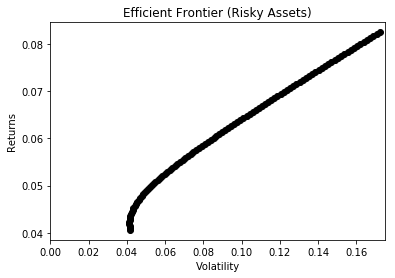

In [461]:
plt.plot(X["PortfolioVol"], X["PortfolioReturn"], 'o', c='k')
# plt.plot(T[" Expected Vol"], T[" Expected Return"])
# plt.plot([0.0451243, 0], [0.0464699, 0.02], 'x')
plt.xlim([0,0.175])
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.title('Efficient Frontier (Risky Assets)')
plt.savefig('/Users/maxlamberti/Codebase/mfe-cpp-prereq/assignment_5/question_1/EfficientFrontier.png')

In [429]:
X[X[" Portfolio Vol"] == X[" Portfolio Vol"].min()]

,Percent Equity,Percent Bond,Portfolio Return,Portfolio Vol
3,0.03,0.97,0.042064,0.041319


In [463]:
T = pd.read_csv('/Users/maxlamberti/Codebase/mfe-cpp-prereq/assignment_5/question_1/cmake-build-debug/TangencyPortfolio.csv')
T.head()

,PercentEquity,PercentBond,PercentCash,ExpectedReturn,Vol
0,0.000000,0.000000,1.000000,0.020201,2.838790e-08
1,0.006926,0.103975,0.889099,0.021785,2.500000e-03
2,0.013851,0.207950,0.778199,0.023368,5.000000e-03
3,0.020777,0.311925,0.667298,0.024952,7.500000e-03
4,0.027702,0.415900,0.556398,0.026535,1.000000e-02


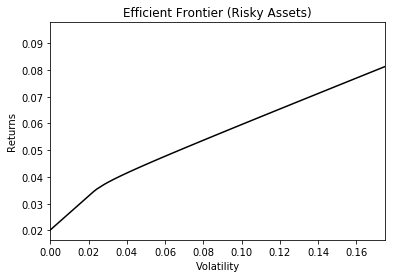

In [466]:
plt.plot(T["Vol"], T["ExpectedReturn"], c='k')
# plt.plot([0.172873, 0], [0.0830156, 0.02], 'x')
plt.xlim([0,0.175])
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.title('Efficient Frontier (Risky Assets)')
plt.savefig('/Users/maxlamberti/Codebase/mfe-cpp-prereq/assignment_5/question_1/EfficientFrontierWithCash.png')

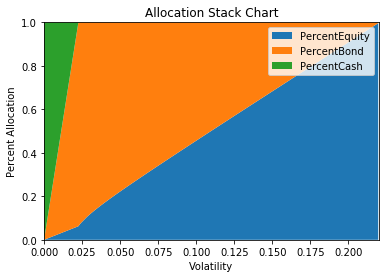

In [476]:
plt.stackplot(T["Vol"], T['PercentEquity'], T['PercentBond'], T['PercentCash'], labels=['PercentEquity', 'PercentBond', 'PercentCash'])
plt.xlim([0,0.22])
plt.ylim([0,1])
plt.legend()
plt.xlabel('Volatility')
plt.ylabel('Percent Allocation')
plt.title('Allocation Stack Chart')
plt.savefig('/Users/maxlamberti/Codebase/mfe-cpp-prereq/assignment_5/question_1/StackChart.png')

In [494]:
Noise = pd.read_csv('/Users/maxlamberti/Codebase/mfe-cpp-prereq/assignment_5/question_2/cmake-build-debug/just_noise.csv')
Noise.head()

,Period,5th,25th,Median,75th,95tn
0,0,0.983671,0.993742,1.00042,1.00698,1.01686
1,1,0.970082,0.988206,1.00075,1.01385,1.03167
2,2,0.957915,0.983600,1.00123,1.01963,1.04510
3,3,0.949228,0.979498,1.00174,1.02448,1.05710
4,4,0.940135,0.975831,1.00160,1.03009,1.06847


In [495]:
ValMom = pd.read_csv('/Users/maxlamberti/Codebase/mfe-cpp-prereq/assignment_5/question_2/cmake-build-debug/value_momentum.csv')
ValMom.head()

,Period,5th,25th,Median,75th,95tn
0,0,0.980837,0.990314,0.997188,1.00400,1.01391
1,1,0.971842,0.984796,0.994117,1.00372,1.01734
2,2,0.965179,0.981987,0.991492,1.00114,1.01845
3,3,0.955634,0.975017,0.988246,1.00131,1.02110
4,4,0.948496,0.969148,0.984497,1.00019,1.02109


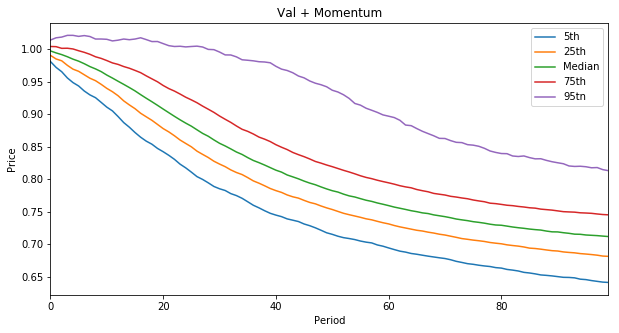

In [501]:
ValMom.plot(x='Period', figsize=(10,5))
plt.ylabel("Price")
plt.title("Val + Momentum")
plt.savefig('/Users/maxlamberti/Codebase/mfe-cpp-prereq/assignment_5/question_2/ValueMomentum.png')

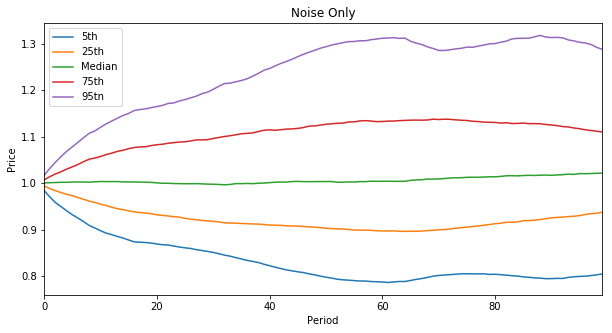

In [502]:
Noise.plot(x='Period', figsize=(10,5))
plt.ylabel("Price")
plt.title("Noise Only")
plt.savefig('/Users/maxlamberti/Codebase/mfe-cpp-prereq/assignment_5/question_2/NoiseOnly.png')